## Python Google Trends API

* https://towardsdatascience.com/google-trends-api-for-python-a84bc25db88f
* https://pypi.org/project/pytrends/
* https://github.com/GeneralMills/pytrends#installation
* https://www.honchosearch.com/blog/seo/how-to-use-python-pytrends-to-automate-google-trends-data/

In [259]:
#!python3.8 -m pip install pytrends
#!python3.8 -m pip install plotly
#!python3.8 -m pip install pycountry

In [589]:
'''
imports
'''
# General imports
from datetime import date
import uuid

# Linear Regression
import pandas as pd   
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import scipy.signal
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score

# Logistic Regression (Churn classification)
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss


## Environment Variables and Authentication

In [614]:
'''
GLOBAL ENVIRONMENT GOOGLE TREND VARIABLES
'''
# Get Dataframe with desired keyoword trend search
pytrend = TrendReq()
#kw_list=['energia solar', 'ahorro energia', 'placas solares', 'energia fotovoltaica', 'energia solar fotovoltaica', 'placa energia solar']
kw_list=['energia solar', 'placas solares']
#kw_list=['energia solar fotovoltaica', 'autoconsumo solar']
directory = "/Users/joan/Workspace/python/py-trends-api/"
out_combined_peaks_filename = ""
timeframe = 'all' # 'today 1-y'
geo_location='ES' # specific country location España
year_start = 2021
year_end = 2021
month_start = 6
month_end = 6
day_start = 21
day_end = 22
hour_start = 0
hour_end = 23

## Functions definition

In [615]:
'''
Get Google trends historical interes iterating month by month the last 2 years,
this will iterate calls to gtrends_historical() month by month.
Returns a pandas Dataframe
'''
# TODO --> set month and day start end instead of starting from current month and day to 0 always

def grends_historical( kw_list, year_start=0, month_start=0, day_start=0, hour_start=0, 
                                    year_end=0, month_end=0, day_end=0, hour_end=0, directory="", category=0, 
                                    geo_location='ES', years_offset = 1):
    
    # Local loop Initializations
    today = date.today() # get current year, month, day and hour
    year = today.year
    month = today.month
    day = today.day
    id = uuid.uuid1()    # get unique identifier for the whole transaccions
    filename_base = "google_trends_historical-"+id.hex+"_" # base name for all the temporal files
    m = month            # initialize to current month, only for the first loop
    day_end = 28         # initialize to minimum month days
    n_files = 0          # initialize to 0 files by default
    years_offset = years_offset # get years to go finding backwards
    
    # iterate month by month backward until begginning the current year and then 5 more
    for y in range(year, year-years_offset, -1):
        for m in range(month, 0, -1):
            if m == 2: # Fabruary has 28 days
                day_end = 28
            else:
                day_end = 30    
            # multi calls for multikeyword and current loop date y and m
            print("Calling gtrends_historical for " + str(y) + " and month: " + str(m) + " and id: " + str(id))
            n_files = gtrends_historical_split_keywords(kw_list, year_start=y, month_start=m, day_start=1, 
                                         hour_start=0, year_end=y, month_end=m, day_end=day_end, 
                                         hour_end=23, save_name=filename_base, directory=directory, 
                                         category=0, geo_location=geo_location, start_from_nfiles=n_files)
            print("Files to be merged: " + str(n_files))
        # end month loop
            
        if m == 1:
            month = 12 # reset month to start the next year        
    # end year loop
    
    # combine multikeyword files
    out_combined_peaks_filename = filename_base+"COMBINED.csv"
    df = combine_wbase(directory, filename_base, n_files, out_combined_peaks_filename)

    return df

In [616]:
'''
 Get Google trends historical Interest by year, month, day and hour
'''
def gtrends_historical_split_keywords(kw_list, year_start=0, month_start=0, day_start=0, hour_start=0, 
                       year_end=0, month_end=0, day_end=0, hour_end=0, 
                       save_name="", directory="", category=0, geo_location='ES', start_from_nfiles=0):
  
    #iterate every 3 item in list
    i = 0
    n_files = start_from_nfiles # 0 by default
    print("Start getting google trends over time from file num: " + str(n_files+1))
    while i < len(kw_list):
        l = kw_list[i:(i+3)]
        df_time = pytrend.get_historical_interest(l, year_start=year_start, month_start=month_start, 
                                                  day_start=day_start, hour_start=hour_start, 
                                                  year_end=year_end, month_end=month_end, day_end=day_end, 
                                                  hour_end=hour_end, cat=category, geo=geo_location, 
                                                  gprop='', sleep=0)
            
        df_time.reset_index(inplace=True) # convert date index into date column
        df_time_name = str(save_name)+str(n_files+1)+".csv"    #+str((i+3)//3)+".csv"
        df_time.to_csv(directory+df_time_name, index = False)
        i += 3
        n_files += 1
        print(df_time_name)
        
    return n_files

In [617]:
def combine_wbase(directory, base_name, n_files, out_filename):
    
    print("Merging CSV " + str(n_files) + " files: ")
    first_file_name = directory+base_name+str(1)+".csv"
    df1 = pd.read_csv(first_file_name)
    print(first_file_name)
    
    # Merge all files
    for i in range(n_files-1):
        filename = directory+base_name+str(i+2)+".csv"
        df2 = pd.read_csv(filename)
        df1 = pd.concat([df1, df2]) #, axis=1, sort=False)
        #df1 =  df1.merge(df2, left_index=True, right_index=True, how='outer', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
        print(filename)
        
    # Drop duplicated columns
    print("Dropping duplicated columns...")
    df1 = df1.loc[:,~df1.columns.duplicated()] # date and isPartial
        
    # Merge duplicated indices
    df1 = df1.groupby(df1.date).sum()
    
    # Date index to column 'date'
    df1.reset_index(inplace=True)
    
    # Saving the merged file or you can simply return the dataframe
    print("Saving file to: " + directory+out_filename)
    df1.to_csv(directory+out_filename, index = False)
    
    
    return df1

In [618]:
# Tidy up IsPartial column for data overtime, eliminates the rows with isPartial == true
# and then drop the column isPartial, when all values are false
def isPartialTidyUp(df, n_file):
    for i in range(n_file-1):
        df = df.drop(columns="isPartial."+str(i+1)+"")
    if df.isPartial.tail(1).bool() == True:
        df = df.drop(df.isPartial.tail(1).index, axis=0)
    df = df.drop(columns="isPartial")
    return df

## Searching for Trends

In [619]:
'''
Test keyword list and store into CSV, month by month to get hourly to avoid timeouts
'''
# single call
#df = pytrend.get_historical_interest(kw_list[0:2], year_start=year_start, month_start=month_start, 
#                                    day_start=day_start, hour_start=hour_start, year_end=year_end, 
#                                    month_end=month_end, day_end=day_end, hour_end=hour_end, cat=0, geo=geo_location, gprop='', sleep=0)

# multi calls for multikeyword
#n_files = gtrends_historical_split_keywords(kw_list[0:6], year_start=year_start, month_start=month_start, day_start=day_start, 
#                             hour_start=hour_start, year_end=year_end, month_end=month_end, day_end=day_end, 
#                             hour_end=hour_end, save_name="gtrends_overtime_MULTIKEYWORD-16-6_", 
#                             directory=directory, category=0, geo_location=geo_location, start_from_nfiles=3)

# combine multikeyword files
#df = combine_wbase(directory, "gtrends_overtime_MULTIKEYWORD-16-6_", n_files, "gtrends_overtime_MULTIKEYWORD-16-6_COMBINED.csv")
#df = combine_wbase(directory, "gtrends_overtime_MULTI-KEYWORD-5YEARS-b6389f7ace9011ebba131e0039143432_", 18, "gtrends_overtime_MULTI-KEYWORD-5YEARS-b6389f7ace9011ebba131e0039143432_COMBINED.csv")
#df = combine_wbase(directory, "gtrends_overtime_MULTI-KEYWORD-5YEARS-0adf4e5aced911ebba131e0039143432_", 56, "gtrends_overtime_MULTI-KEYWORD-5YEARS-0adf4e5aced911ebba131e0039143432_COMBINED.csv")

df = grends_historical( kw_list, year_start=year_start, month_start=month_start, day_start=day_start, 
                        hour_start=hour_start, year_end=year_end, month_end=month_end, day_end=day_end, 
                        hour_end=hour_end, directory=directory, category=0, geo_location=geo_location,
                        years_offset = 1)

df

Calling gtrends_historical for 2021 and month: 6 and id: 441370a6-d344-11eb-ba13-1e0039143432
Start getting google trends over time from file num: 1
HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)
The request failed: Google returned a response with code 400.
google_trends_historical-441370a6d34411ebba131e0039143432_1.csv
Files to be merged: 1
Calling gtrends_historical for 2021 and month: 5 and id: 441370a6-d344-11eb-ba13-1e0039143432
Start getting google trends over time from file num: 2
HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)
HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)
google_trends_historical-441370a6d34411ebba131e0039143432_2.csv
Files to be merged: 2
Calling gtrends_historical for 2021 and month: 4 and id: 441370a6-d344-11eb-ba13-1e0039143432
Start getting google trends over time from file num: 3
HTTPSConnectionPool(host='trends.google.com', por

,date,energia solar fotovoltaica,autoconsumo solar,isPartial
0,2021-01-01 00:00:00,4,11,0
1,2021-01-01 01:00:00,5,0,0
2,2021-01-01 02:00:00,0,0,0
3,2021-01-01 03:00:00,0,0,0
4,2021-01-01 04:00:00,25,0,0
...,...,...,...,...
2673,2021-06-22 06:00:00,53,53,0
2674,2021-06-22 07:00:00,38,86,0
2675,2021-06-22 08:00:00,41,50,0
2676,2021-06-22 09:00:00,72,88,0


## Processing Data

In [620]:
# Convert date index to new column date
#df.reset_index(inplace=True) # already done in multi keyword function

# Tidy up isPartial data (estimated)
#df = isPartialTidyUp(df,1)

# Drop duplicated columns
#print("Dropping duplicated columns...")
#df = df.loc[:,~df.columns.duplicated()] # date and isPartial

# Cast date object column into datetime column
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')

# Split date into year, month, day and hour
df['year'], df['month'], df['day'], df['hour'] = df['date'].apply(lambda x: x.year), df['date'].apply(lambda x: x.month), df['date'].apply(lambda x: x.day), df['date'].apply(lambda x: x.hour)

# Drop date column
#df = df.drop(columns="date") # will be needed for predictions, it is better to filter in a new dataframe

# Interest statistics
#df['googleInterest'] = df[kw_list[0]]

# Transpose column name with keywords kw_list[i] into a column value within a new column named 'keyword'
#df['keyword'] = kw_list[0]
#df = df.drop(columns=kw_list[0])

# Add location column
df['geo_location'] = geo_location # geo_location translated to spanish description from ISO2 ES code

# Calculate the min interest
df['min_interest'] = df[df.columns[1:(len(kw_list)+1)]].min(axis=1) # Horitzontal min for the keyword columns

# Calculate the max interest
df['max_interest'] = df[df.columns[1:(len(kw_list)+1)]].max(axis=1) # Horitzontal max for the keyword columns

# Calculate the average interest
df['google_interest'] = df[df.columns[1:(len(kw_list)+1)]].mean(axis=1) # Horitzontal mean for the keyword columns

df.head()

,date,energia solar fotovoltaica,autoconsumo solar,isPartial,year,month,day,hour,geo_location,min_interest,max_interest,google_interest
0,2021-01-01 00:00:00,4,11,0,2021,1,1,0,ES,4,11,7.5
1,2021-01-01 01:00:00,5,0,0,2021,1,1,1,ES,0,5,2.5
2,2021-01-01 02:00:00,0,0,0,2021,1,1,2,ES,0,0,0.0
3,2021-01-01 03:00:00,0,0,0,2021,1,1,3,ES,0,0,0.0
4,2021-01-01 04:00:00,25,0,0,2021,1,1,4,ES,0,25,12.5


In [579]:
# data visualization 

viz = df[['date', 'ahorro corriente', 'ahorro energia', 'energia solar',
       'placas solares', 'energia fotovoltaica', 'energia solar fotovoltaica',
       'placa energia solar', 'year', 'month', 'day', 'hour', 'geo_location',
       'min_interest', 'max_interest', 'google_interest']] #['ahorro consumo energetico','ahorro corriente','ahorro energia','energia solar', 'placas solares','max_interest','year','month','day','hour', 'google_interest']]
viz.hist()
plt.show()

'''
we can drop, without relation:
- ahorro energia
- ahorro corriente
- placa energia solar
- min_interest
- year
- month
- day (non lineal correlation)
- hour (non lineal correlation)

we will keep, lineal relation:
- energia solar
- placas solares
- energia fotovoltaica
- energia solar fotovoltaica
- max_interest

non lineal relations
- day (non lineal correlation)
- hour (non lineal correlation)
'''

KeyError: "['energia solar fotovoltaica', 'energia fotovoltaica', 'ahorro corriente', 'ahorro energia', 'placa energia solar'] not in index"

In [621]:
# relationship vars 

plt.scatter(df['energia solar'], df.google_interest,  color='blue')
plt.xlabel("Avg ")
plt.ylabel("max")
plt.show()

KeyError: 'energia solar'

In [622]:
# Test and Train dataset

msk = np.random.rand(len(df)) < 0.3
train = df[msk]
test = df[~msk]

Coefficients:  [[0.66]]


Text(0, 0.5, 'google_interest')

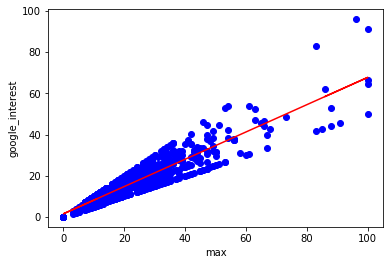

In [623]:
# LINEAR REGRESSION
#from sklearn import linear_model

# model train and fit parameters
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['max_interest']]) 
y = np.asanyarray(train[['google_interest']])
regr.fit (x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

plt.scatter(train[['max_interest']], train.google_interest,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
plt.xlabel("max")
plt.ylabel("google_interest")

In [624]:
# Accuracy error
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['max_interest']])
test_y = np.asanyarray(test[['google_interest']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Mean absolute error: 3.10
Residual sum of squares (MSE): 18.93
R2-score: 0.85


In [628]:
# Regression MULTI
#from sklearn import linear_model

regr = linear_model.LinearRegression()
x = np.asanyarray(train[['energia solar fotovoltaica', 'autoconsumo solar']]) #['energia solar','placas solares']])
y = np.asanyarray(train[['google_interest']])
regr.fit (x, y)

# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.5 0.5]]


In [629]:
# Regression MULTI

y_hat= regr.predict(test[['energia solar fotovoltaica', 'autoconsumo solar']]) #['energia solar','placas solares']])
x = np.asanyarray(test[['energia solar fotovoltaica', 'autoconsumo solar']]) #
y = np.asanyarray(test[['google_interest']])
print("Residual sum of squares: %.2f"  % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , y_hat) )

Residual sum of squares: 0.00
Variance score: 1.00
Mean absolute error: 0.00
Residual sum of squares (MSE): 0.00
R2-score: 1.00


In [586]:
'''
Country code map test
'''

import pycountry

input_countries = ['Spain']

# Load countries dict
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

#print(countries)
codes = [countries.get(country, 'Unknown code') for country in input_countries]

print(codes)  # prints ['AS', 'CA', 'FR']


['ES']


In [630]:
# Save Dataset into CSV file
df.to_csv(directory +     out_combined_peaks_filename, index = False)
print("Saved to: " + directory +     out_combined_peaks_filename)

IsADirectoryError: [Errno 21] Is a directory: '/Users/joan/Workspace/python/py-trends-api/'

In [497]:
# Load Dataset from CSV file
df = pd.read_csv(directory + 'gtrends_historical_7cbefa1ecf3f11ebba131e0039143432_COMBINED_PEAKS.csv')

In [498]:
df.head()

,date,energia solar,ahorro corriente,ahorro energia,isPartial,placas solares,energia fotovoltaica,energia solar fotovoltaica,placa energia solar,year,month,day,hour,geo_location,min_interest,max_interest,avg_interest,is_peak
0,2021-01-01 00:00:00,9.0,0.0,11.0,0,20.0,1.0,1.0,10.0,2021,1,1,0,ES,0.0,20.0,6.000000,0
1,2021-01-01 01:00:00,20.0,0.0,10.0,0,19.0,3.0,1.0,0.0,2021,1,1,1,ES,0.0,20.0,7.571429,0
2,2021-01-01 02:00:00,43.0,0.0,25.0,0,29.0,0.0,0.0,0.0,2021,1,1,2,ES,0.0,43.0,13.857143,1
3,2021-01-01 03:00:00,33.0,0.0,0.0,0,19.0,0.0,0.0,0.0,2021,1,1,3,ES,0.0,33.0,7.428571,0
4,2021-01-01 04:00:00,46.0,0.0,0.0,0,40.0,7.0,7.0,70.0,2021,1,1,4,ES,0.0,46.0,14.285714,0


In [72]:
# TODO --> add isTrendPeak column with the top peaks market over threashold of 25%

Peaks are: [   5    7   13   15   17   21   25   30   35   37   39   41   51   53
   56   58   63   65   69   72   77   79   88   93   98  100  102  107
  111  119  121  126  135  139  143  147  149  153  156  161  168  171
  173  176  180  184  189  192  195  198  201  207  211  214  216  221
  224  228  231  233  235  237  239  241  243  248  251  257  261  265
  267  270  276  278  282  287  291  295  297  302  306  310  313  316
  321  324  326  329  332  334  338  341  343  346  351  356  360  362
  364  366  370  373  378  381  387  389  394  396  399  406  410  413
  417  420  426  431  436  441  450  452  459  462  467  472  479  481
  486  492  498  504  506  508  512  514  518  521  525  529  531  538
  541  546  550  552  558  561  564  566  571  574  579  581  584  592
  594  602  604  606  609  618  620  623  625  628  633  636  638  642
  646  651  654  656  660  663  669  672  676  681  685  688  693  697
  702  705  707  710  712  715  718  720  723  725  729  732  735 

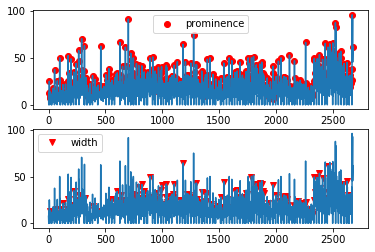

In [631]:
# Peaks detection

x = np.array(df['google_interest'])
#peaks, _ = find_peaks(x, distance=20)
peaks2, _ = find_peaks(x, prominence=3)      
peaks3, _ = find_peaks(x, width=2)
#peaks4, _ = find_peaks(x, threshold=2)  

# print the peaks
print('Peaks are: %s' % (peaks2))

# visualize and compare peaks detectors
#plt.subplot(2, 1, 1)
#plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance']) # ko
plt.subplot(2, 1, 1)
plt.plot(peaks2, x[peaks2], "or"); plt.plot(x); plt.legend(['prominence']) # BEST !
plt.subplot(2, 1, 2)
plt.plot(peaks3, x[peaks3], "vr"); plt.plot(x); plt.legend(['width'])  # BEST !
#plt.subplot(2, 1, 2)
#plt.plot(peaks4, x[peaks4], "or"); plt.plot(x); plt.legend(['threshold']) # ko

plt.show()

In [632]:
# Mark registry as a peak 1 = true or not 0 = false
df['is_peak'] = 0
for i in peaks2:
    df.loc[i,['is_peak']] = 1

filter = df['is_peak'] == 1 # check updates
df[filter]

,date,energia solar fotovoltaica,autoconsumo solar,isPartial,year,month,day,hour,geo_location,min_interest,max_interest,google_interest,is_peak
5,2021-01-01 05:00:00,26,0,0,2021,1,1,5,ES,0,26,13.0,1
7,2021-01-01 07:00:00,25,25,0,2021,1,1,7,ES,25,25,25.0,1
13,2021-01-01 13:00:00,6,9,0,2021,1,1,13,ES,6,9,7.5,1
15,2021-01-01 15:00:00,11,6,0,2021,1,1,15,ES,6,11,8.5,1
17,2021-01-01 17:00:00,10,17,0,2021,1,1,17,ES,10,17,13.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,2021-06-21 17:00:00,24,26,0,2021,6,21,17,ES,24,26,25.0,1
2665,2021-06-21 22:00:00,16,37,0,2021,6,21,22,ES,16,37,26.5,1
2667,2021-06-22 00:00:00,0,77,0,2021,6,22,0,ES,0,77,38.5,1
2670,2021-06-22 03:00:00,96,96,0,2021,6,22,3,ES,96,96,96.0,1


In [633]:
# Lets select some features for the modeling. Also we change the target data type to be integer, as it is a requirement by the skitlearn algorithm:
# churn_df = df[['placas solares','max_interest', 'google_interest','is_peak']]
# churn is is_peak column
df['is_peak'] = df['is_peak'].astype('int')
df.head()

,date,energia solar fotovoltaica,autoconsumo solar,isPartial,year,month,day,hour,geo_location,min_interest,max_interest,google_interest,is_peak
0,2021-01-01 00:00:00,4,11,0,2021,1,1,0,ES,4,11,7.5,0
1,2021-01-01 01:00:00,5,0,0,2021,1,1,1,ES,0,5,2.5,0
2,2021-01-01 02:00:00,0,0,0,2021,1,1,2,ES,0,0,0.0,0
3,2021-01-01 03:00:00,0,0,0,2021,1,1,3,ES,0,0,0.0,0
4,2021-01-01 04:00:00,25,0,0,2021,1,1,4,ES,0,25,12.5,0


In [634]:
# Save Dataset into CSV file
df.to_csv(directory +     out_combined_peaks_filename, index = False)
print("Saved file csv to: " +directory +     out_combined_peaks_filename)

IsADirectoryError: [Errno 21] Is a directory: '/Users/joan/Workspace/python/py-trends-api/'

## Logistic Regression for is_peak prediction

In [602]:
# Lets define X, and y for our dataset:
#X = np.asarray(df[['ahorro energia','energia solar', 'placas solares','google_interest','max_interest','year','month','day','hour']])
X = np.asarray(df[['year','month','day','hour','energia solar','placas solares','max_interest','google_interest']])
#X = np.asarray(df[['energia solar','placas solares','energia fotovoltaica','energia solar fotovoltaica','max_interest','google_interest']])
X[0:5]
y = np.asarray(df['is_peak'])
y [0:5]

# Also, we normalize the dataset:
# from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.  , -1.43, -1.6 , -1.66, -1.45, -2.08, -2.08, -2.18],
       [ 0.  , -1.43, -1.6 , -1.51, -0.7 , -2.21, -2.22, -2.01],
       [ 0.  , -1.43, -1.6 , -1.37,  0.8 , -1.46, -1.47, -0.88],
       [ 0.  , -1.43, -1.6 , -1.22,  0.05, -2.14, -2.15, -1.69],
       [ 0.  , -1.43, -1.6 , -1.08,  0.95, -0.71, -0.72, -0.23]])

In [603]:
# Train and test Dataset
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2611, 8) (2611,)
Test set: (1119, 8) (1119,)


In [604]:
# Train the model
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LRyhat = LR.predict(X_test)

# Now we can predict using our test set:
yhat = LR.predict(X_test)
yhat

array([0, 0, 1, ..., 0, 0, 0])

In [605]:
#predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.84, 0.16],
       [0.88, 0.12],
       [0.36, 0.64],
       ...,
       [0.91, 0.09],
       [0.9 , 0.1 ],
       [0.72, 0.28]])

In [606]:
# Evaluation
# Jaccard
# from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)


0.7889641819941917

In [607]:
# Evaluation
# Confusion Matrix
#from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 86 172]
 [ 46 815]]


Confusion matrix, without normalization
[[ 86 172]
 [ 46 815]]


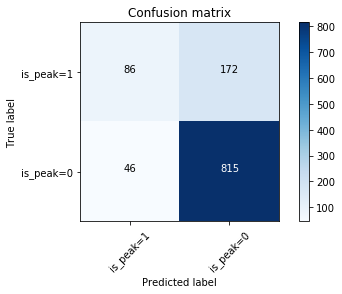

In [608]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['is_peak=1','is_peak=0'],normalize= False,  title='Confusion matrix')

### Results

In [609]:
# With: ['ahorro energia','energia solar', 'placas solares','google_interest','max_interest','year','month','day','hour']
# Results: 2 of 6 is_peak=1 predicted well, 57 of 62 is_peak=0 predicted well --> 0,31% accur

# With: ['placas solares','max_interest', 'google_interest']
# Results: 2 of 6 is_peak=1 predicted well, 59 of 62 is_peak=0 predicted well --> 0,40% accur

# With: ['placas solares','max_interest', 'google_interest','year','month','day','hour']
# Results: 2 of 6 is_peak=1 predicted well, 58 of 62 is_peak=0 predicted well --> 0,33% accur

# With: ['energia solar','placas solares','energia fotovoltaica','energia solar fotovoltaica','max_interest','google_interest']
# Results: 6 of 8 is_peak=1 predicted well, 51 of 60 is_peak=0 predicted well -->0,40 accur prec 1, 0,84 avrg

# With ['placas solares', 'max_interest', 'google_interest']
# Results: 5 of 8 is_peak=1 predicted well, 58 of 60 is_peak_=0 predicted well --> 0,67% accur precision in 1 (0,93 avg)

# --> BEST <-- 
# With ['placas solares','energia solar', 'max_interest', 'google_interest']
# Results: 4 of 6 is_peak=1 predicted well, 42 of 46 is_peak_=0 predicted well --> 0,62% accur precision in 1 (0,90 avg)

In [610]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       861
           1       0.65      0.33      0.44       258

    accuracy                           0.81      1119
   macro avg       0.74      0.64      0.66      1119
weighted avg       0.79      0.81      0.78      1119



In [564]:
# Log loss
# from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.42482261171906704

In [ ]:
# TODO --> split N calls of interest_by_region and merge them all by N historical_interest for each region in the same timeframe

In [ ]:
'''
DETALLE POR HORA NO APORTA NADA A ESTE NIVEL, NO APRENDE MEJOR.
EL DETALLE POR REGION DEBE INCORPORARSE MES A MES -> COLUMNS geoName + geoCode
'''

## Region historical interest split

In [499]:
df = pd.read_csv(directory + 'gtrends_historical_7cbefa1ecf3f11ebba131e0039143432_COMBINED_PEAKS.csv')

In [500]:
# Interest by Regio
pytrend.build_payload(kw_list=kw_list[0:3], geo='', timeframe='today 1-m')

df2 = pytrend.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=True)
#df2.sort_values(by=['energia solar'], ascending=False)
print(df2.head(25))

                    geoCode  energia solar  ahorro energia  placas solares
geoName                                                                   
Andalusia             ES-AN             20               6              74
Aragon                ES-AR             10               0              90
Asturias              ES-AS             25              12              63
Balearic Islands      ES-IB             25               0              75
Basque Country        ES-PV             34               6              60
Canary Islands        ES-CN             42               5              53
Cantabria             ES-CB             67               0              33
Castile and León      ES-CL             20               6              74
Castile-La Mancha     ES-CM             20              10              70
Catalonia             ES-CT             27               6              67
Ceuta                 ES-CE              0               0               0
Community of Madrid   ES-

In [508]:
# look for the date where a kw is_peak is True (1) 
# and then call interest_by_region for that kw and date
# Load Dataset from CSV file

peaks_list = df['is_peak'] == 1
df_peaks = df[peaks_list]
df_peaks = df_peaks.groupby([df_peaks.year, df_peaks.month, df_peaks.day]).sum()
df_peaks.head(25)

energia solar  ahorro corriente  ahorro energia  isPartial  \
year month day                                                               
2021 1     1            103.0               1.0            50.0          0   
           2            109.0              25.0            32.0          0   
           3            155.0               0.0            54.0          0   
           4            130.0               1.0             7.0          0   
           5            150.0               4.0            12.0          0   
           6            213.0               2.0            70.0          0   
           7             77.0               4.0            39.0          0   
           8            225.0               5.0            57.0          0   
           9             53.0               0.0             0.0          0   
           10           206.0              19.0            41.0          0   
           11           267.0               9.0            33.0          0   
           12           217.0               6.0            36.0          0   
           13           206.0               3.0            46.0          0   
           14           163.0               2.0            92.0          0   
           15           118.0               1.0            23.0          0   
           16            26.0               0.0             6.0          0   
           17            48.0               1.0            10.0          0   
           18            21.0               0.0             4.0          0   
           19            39.0               1.0             8.0          0   
           20           122.0               1.0            11.0          0   
           21            21.0               1.0             6.0          0   
           22           179.0              17.0            45.0          0   
           23           239.0               1.0            21.0          0   
           24           121.0               6.0            10.0          0   
           25           200.0               5.0            32.0          0   

                placas solares  energia fotovoltaica  \
year month day                                         
2021 1     1             172.0                   9.0   
           2             227.0                  23.0   
           3             175.0                  13.0   
           4              84.0                   5.0   
           5             228.0                  33.0   
           6             261.0                  15.0   
           7             123.0                   7.0   
           8             322.0                  27.0   
           9              99.0                   0.0   
           10            272.0                  18.0   
           11            264.0                  29.0   
           12            260.0                  22.0   
           13            275.0                  40.0   
           14            230.0                  28.0   
           15            304.0                   9.0   
           16            129.0                  16.0   
           17            214.0                  25.0   
           18             65.0                   7.0   
           19            169.0                   8.0   
           20            172.0                  40.0   
           21             59.0                   5.0   
           22            190.0                  17.0   
           23            271.0                  13.0   
           24            118.0                   2.0   
           25            163.0                  10.0   

                energia solar fotovoltaica  placa energia solar  hour  \
year month day                                                          
2021 1     1                           4.0                  8.0    31   
           2                           7.0                  7.0    38   
           3                          11.0                 18.0    25   
           4                   